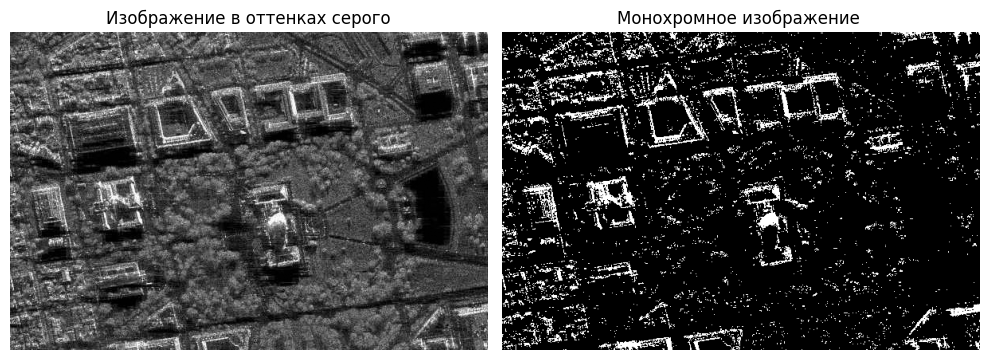

In [33]:
# 1. Сохранение монохромного изображения в виде текстового или бинарного файла.
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread("sar_1_gray.jpg", cv2.IMREAD_GRAYSCALE)
_, mono = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY)
img.tofile("image_binary.raw")

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(img, cmap="gray")
axes[0].set_title("Изображение в оттенках серого")
axes[0].axis("off")

axes[1].imshow(mono, cmap="gray")
axes[1].set_title("Монохромное изображение ")
axes[1].axis("off")

plt.tight_layout()
plt.show()

np.savetxt("image_mono.txt", mono, fmt="%d")
mono.tofile("image_mono.raw")

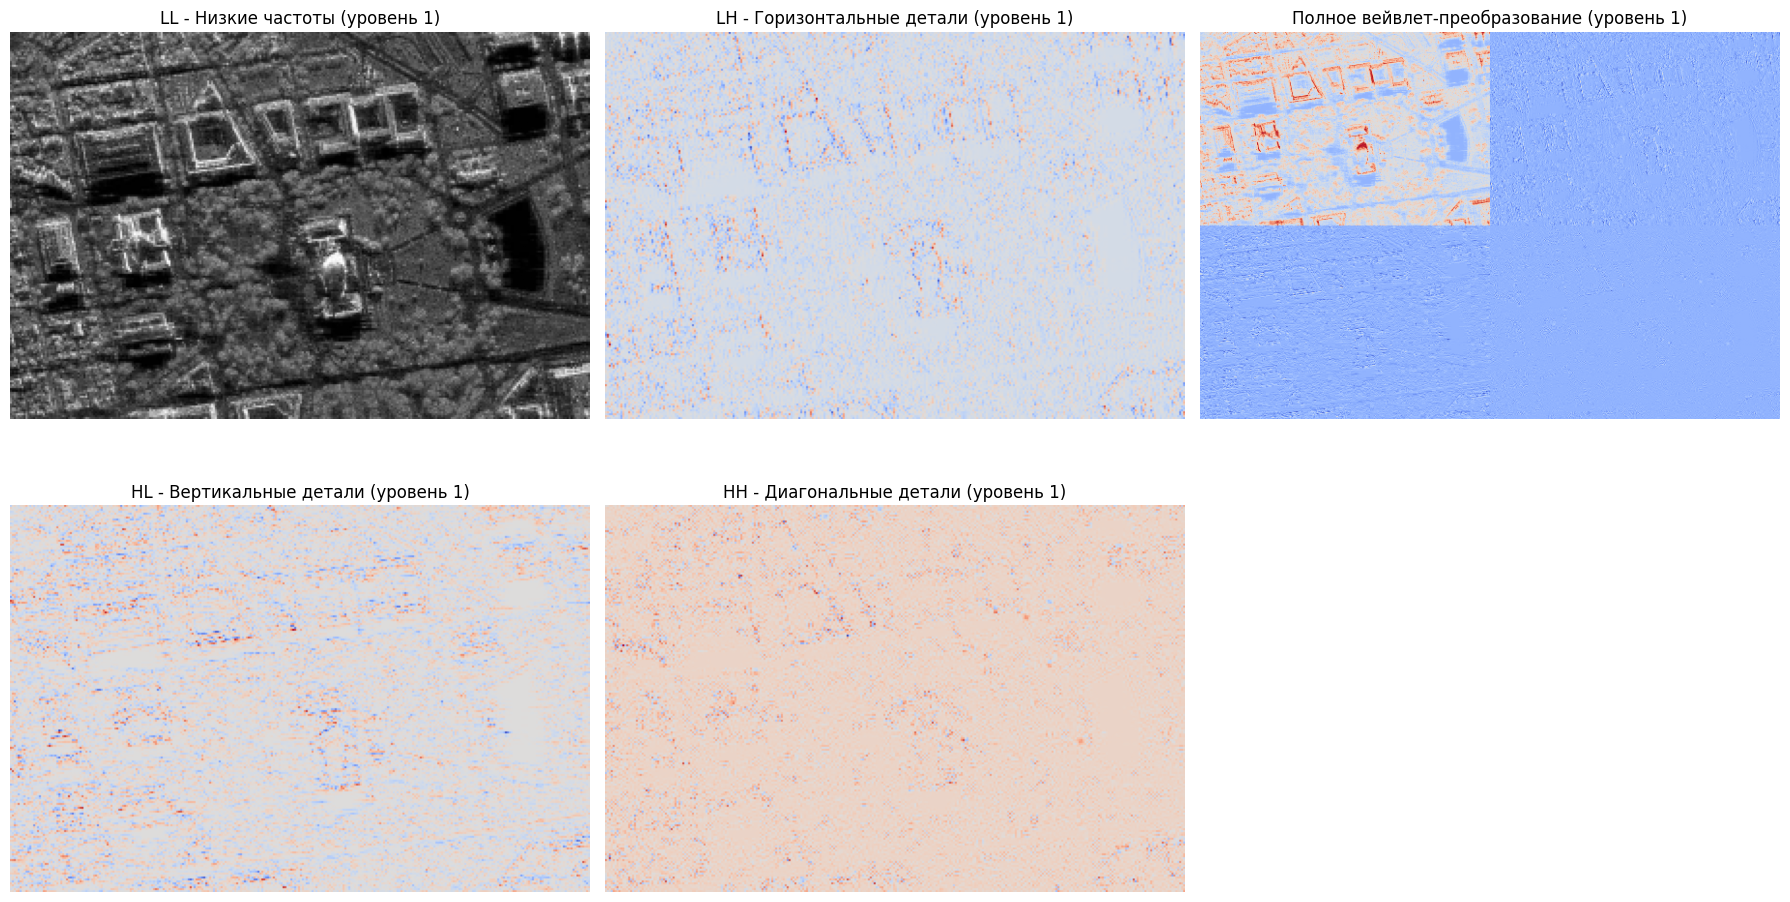

In [34]:
# 2. Реализуйте алгоритм вейвлет-преобразования Хаара для изображения.
def haar_transform(img):
    img = img.astype(np.float32)
    h, w = img.shape

    low_h = (img[:, 0::2] + img[:, 1::2]) / 2
    high_h = (img[:, 0::2] - img[:, 1::2]) / 2

    temp = np.hstack((low_h, high_h))

    low_v = (temp[0::2, :] + temp[1::2, :]) / 2
    high_v = (temp[0::2, :] - temp[1::2, :]) / 2

    result = np.vstack((low_v, high_v))

    ll = result[:h // 2, :w // 2]
    lh = result[:h // 2, w // 2:]
    hl = result[h // 2:, :w // 2]
    hh = result[h // 2:, w // 2:]

    return ll, lh, hl, hh, result

wavelets = []   
current = img.astype(np.float32)
for lvl in range(levels):
    ll, lh, hl, hh, full = haar_transform(current)
    wavelets.append((ll, lh, hl, hh, full))
    current = ll  

plt.figure(figsize=(18, 10))

ll1, lh1, hl1, hh1, full1 = wavelets[0]

plt.subplot(2, 3, 3)
plt.imshow(full1, cmap='coolwarm')
plt.title('Полное вейвлет-преобразование (уровень 1)')
plt.axis('off')

# LL
plt.subplot(2, 3, 1)
plt.imshow(ll1, cmap='gray')
plt.title('LL - Низкие частоты (уровень 1)')
plt.axis('off')

# LH
plt.subplot(2, 3, 2)
plt.imshow(lh1, cmap='coolwarm')
plt.title('LH - Горизонтальные детали (уровень 1)')
plt.axis('off')

# HL
plt.subplot(2, 3, 4)
plt.imshow(hl1, cmap='coolwarm')
plt.title('HL - Вертикальные детали (уровень 1)')
plt.axis('off')

# HH
plt.subplot(2, 3, 5)
plt.imshow(hh1, cmap='coolwarm')
plt.title('HH - Диагональные детали (уровень 1)')
plt.axis('off')

plt.tight_layout()
plt.show()

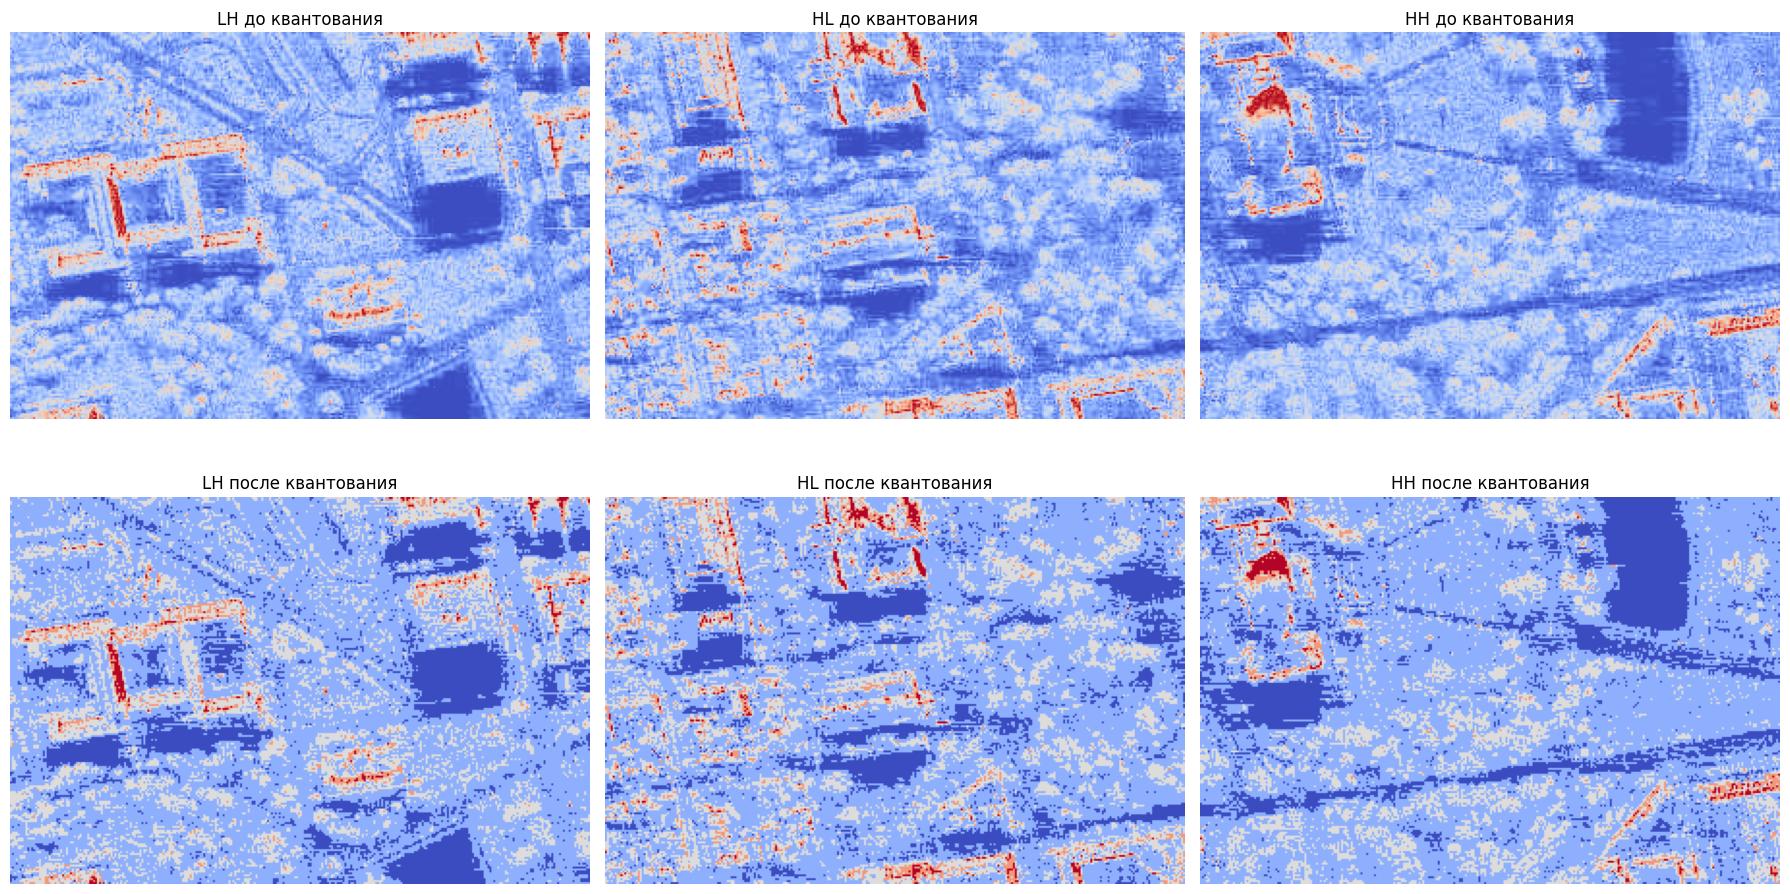

In [35]:
# Задача 3. Квантование высокочастотных компонент (количество квантов = 4).
def quantize(component, n_quants):
    min_val = np.min(component)
    max_val = np.max(component)
    step = (max_val - min_val) / n_quants
    quantized = np.round((component - min_val) / step).astype(int)
    return quantized, min_val, step

def dequantize(quantized, min_val, step):
    return min_val + quantized * step

num_quants = 4
LH_q, LH_min, LH_step = quantize(LH, num_quants)
HL_q, HL_min, HL_step = quantize(HL, num_quants)
HH_q, HH_min, HH_step = quantize(HH, num_quants)

LH_restored = dequantize(LH_q, LH_min, LH_step)
HL_restored = dequantize(HL_q, HL_min, HL_step)
HH_restored = dequantize(HH_q, HH_min, HH_step)

plt.figure(figsize=(18, 10))

plt.subplot(2, 3, 1)
plt.imshow(LH, cmap='coolwarm')
plt.title('LH до квантования')
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(HL, cmap='coolwarm')
plt.title('HL до квантования')
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(HH, cmap='coolwarm')
plt.title('HH до квантования')
plt.axis('off')

plt.subplot(2, 3, 4)
plt.imshow(LH_restored, cmap='coolwarm')
plt.title('LH после квантования')
plt.axis('off')

plt.subplot(2, 3, 5)
plt.imshow(HL_restored, cmap='coolwarm')
plt.title('HL после квантования')
plt.axis('off')

plt.subplot(2, 3, 6)
plt.imshow(HH_restored, cmap='coolwarm')
plt.title('HH после квантования')
plt.axis('off')

plt.tight_layout()
plt.show()

In [36]:
# Сохраните получившийся массив значений в текстовый или бинарный файл в порядке LL,
# LH, HL, HH вейвлет-преобразования Хафа. Компоненты LH, HL, HH храните в виде пар
# (значение, количество повторений).
def rle_encode(array):
    flat = array.flatten()
    result = []
    count = 1
    for i in range(1, len(flat)):
        if flat[i] == flat[i-1]:
            count += 1
        else:
            result.append((int(flat[i-1]), count))
            count = 1
    result.append((int(flat[-1]), count))
    return result

LH_rle = rle_encode(LH_q)
HL_rle = rle_encode(HL_q)
HH_rle = rle_encode(HH_q)

with open("haar_result.bin", "wb") as f:
    f.write(LL.astype(np.float32).tobytes())
    for comp in [LH_rle, HL_rle, HH_rle]:
        for val, cnt in comp:
            f.write(np.uint8(val).tobytes())
            f.write(np.uint16(cnt).tobytes())

In [41]:
# Сравните объем памяти, занимаемый исходным изображением (попиксельное хранение), и
# изображение, полученным после преобразования Хафа и сжатием длин серий.
orig_size = os.path.getsize("image_binary.raw")
compressed_size = os.path.getsize("haar_result.bin")

print(f"Исходный размер: {orig_size} байт")
print(f"После Хаара: {compressed_size} байт")
print(f"Коэффициент сжатия: {orig_size / compressed_size}")

Исходный размер: 240000 байт
После Хаара: 384309 байт
Коэффициент сжатия: 0.6244974746883367
